In [2]:
import numpy as np
###################################
######## Load the data ###########

# Path to the folder containing the files
base_path16 = "/Users/annagarbo1/Desktop/Numerical Methods in Soft Matter/seconda metà esercizi/A13/hist_16"
base_path32 = "/Users/annagarbo1/Desktop/Numerical Methods in Soft Matter/seconda metà esercizi/A13/hist_32"
base_path48 = "/Users/annagarbo1/Desktop/Numerical Methods in Soft Matter/seconda metà esercizi/A13/hist_48"

# List of file names
file_names = ["hist_1.txt", "hist_2.txt", "hist_3.txt",
              "hist_4.txt", "hist_5.txt", "hist_6.txt",
              "hist_7.txt"]

data16 = []
for file_name in file_names:
    full_path = f"{base_path16}/{file_name}"
    with open(full_path, 'r') as file:
        file_data = np.loadtxt(file)
        data16.append(file_data)
        
data32 = []       
for file_name in file_names:
    full_path = f"{base_path32}/{file_name}"
    with open(full_path, 'r') as file:
        file_data = np.loadtxt(file)
        data32.append(file_data)

data48 = []
for file_name in file_names:
    full_path = f"{base_path48}/{file_name}"
    with open(full_path, 'r') as file:
        file_data = np.loadtxt(file)
        data48.append(file_data)

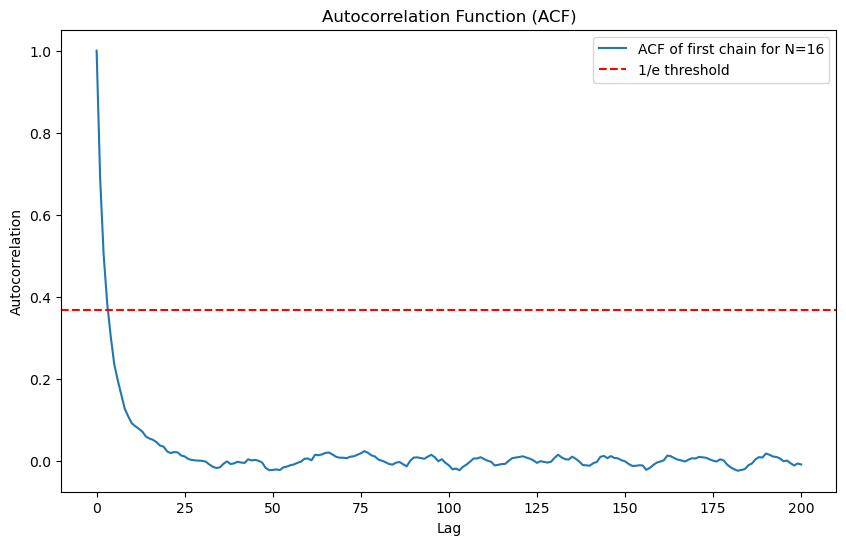

Autocorrelation times for data16:
[8, 28, 20, 8, 6, 4, 4]

Autocorrelation times for data32:
[8, 106, 12, 6, 4, 4, 4]

Autocorrelation times for data48:
[8, 60, 12, 8, 6, 4, 4]


In [3]:
import matplotlib.pyplot as plt        
###################################
######## Extract energy ###########
data16_e = [data16[i][:,1]*16**2 for i in range(7)]
data32_e = [data32[i][:,1]*32**2 for i in range(7)]
data48_e = [data48[i][:,1]*48**2 for i in range(7)]


###################################
######### Compute acf #############
from statsmodels.tsa.stattools import acf

def compute_acf(data, nlags=200):
    acfs = []
    for chain in data:
        acf_values = acf(chain, nlags=nlags)
        acfs.append(acf_values)
    return acfs

def compute_autocorrelation_time(acf_values):
    """Compute the autocorrelation time based on the point where ACF decays to 1/e."""
    threshold = 1 / np.exp(1)
    for lag, value in enumerate(acf_values):
        if value < threshold:
            tau = lag
            break
    else:
        tau = len(acf_values)  # if no such point is found within nlags, use the max lag
    return 2 * tau

# compute ACF for each set of data
acf16 = compute_acf(data16_e)
acf32 = compute_acf(data32_e)
acf48 = compute_acf(data48_e)

# compute autocorrelation time for each set of data
tau16 = [compute_autocorrelation_time(acf_chain) for acf_chain in acf16]
tau32 = [compute_autocorrelation_time(acf_chain) for acf_chain in acf32]
tau48 = [compute_autocorrelation_time(acf_chain) for acf_chain in acf48]

# as an example: Plot ACF for the first chain in data20_e
plt.figure(figsize=(10, 6))
plt.plot(acf16[0], label='ACF of first chain for N=16')
plt.axhline(y=1/np.exp(1), color='r', linestyle='--', label='1/e threshold')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Autocorrelation Function (ACF)')
plt.show()

# print the autocorrelation times
print("Autocorrelation times for data16:")
print(tau16)
print("\nAutocorrelation times for data32:")
print(tau32)
print("\nAutocorrelation times for data48:")
print(tau48)


###################################
##### Subsample the data #########

def subsample_data(data, taus):
    """Subsample data according to the computed autocorrelation times."""
    subsampled_data = []
    for chain, tau in zip(data, taus):
        subsampled_chain = chain[::tau]
        subsampled_data.append(subsampled_chain)
    return subsampled_data

data16 = subsample_data(data16_e, tau16)
data32 = subsample_data(data32_e, tau32)
data48 = subsample_data(data48_e, tau48)

In [3]:
def rescale_z(x):
    minimum = np.min(x)
    maximum = np.max(x)
    A = 1.0 / np.sqrt(minimum * maximum)
    x_new = [val * A for val in x]
    return x_new

def convergence(Z_k_new, Z_k_old):
    delta = [( (Z_k_new[k] - Z_k_old[k]) / Z_k_new[k] )**2 for k in range(len(Z_k_new))]
    return np.sum(delta)

In [4]:
def compute_partition_functions(data16, T_critic, num_iterations=500, tolerance=1e-5,verbose=True):
    # Define M vector
    M = []
    for j in range(len(data16)): 
        M.append(data16[j].shape[0])
    
    # Define the betas
    T = np.linspace(T_critic, 1.5 * T_critic, 7)
    betas = 1 / T
    num_temperatures = len(T)

    # Initializing partition functions Z for each temperature
    Z_old = np.ones(num_temperatures)  # Start with ones to avoid division by zero
    Z_new = np.ones(num_temperatures)

    # Main loop for iterations
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}")
        for k in range(num_temperatures):  # Compute Z at a given temperature k
            summation = 0
            for i in range(num_temperatures):
                for n in range(data16[i].shape[0]):
                    denominator_sum = 0
                    for j in range(num_temperatures):
                        E_in = data16[i][n]
                        denominator_sum += M[j] * (1 / Z_old[j]) * np.exp((betas[k] - betas[j]) * E_in)
                    summation += 1.0 / denominator_sum
            Z_new[k] = summation
        
        # Check for convergence
        if convergence(Z_new, Z_old) < tolerance**2:
            break    
        
        # Update Z_old with Z_new for the next iteration
        Z_new = rescale_z(Z_new)
        Z_old = Z_new.copy()
        if verbose:
            print(f"Z_new after iteration {iteration + 1}: {Z_new}")

    # Final Z values
    Z_final = Z_new
    print(f"Final Z values: {Z_final}")
    return Z_final
T_critic=2.5
Z_final = compute_partition_functions(data16, T_critic)

Iteration 1
Z_new after iteration 1: [10826.753465455417, 32.724018852488754, 0.6034335440707942, 0.029957909571900674, 0.002888185581866539, 0.00043997924759325965, 9.23637915272264e-05]
Iteration 2
Z_new after iteration 2: [119838.95846828212, 167.7645637517636, 1.3542172790623928, 0.028239264466629447, 0.0011635064795385143, 8.04291285247162e-05, 8.344531801523216e-06]
Iteration 3
Z_new after iteration 3: [462661.0854994292, 330.1894210847845, 1.5551638624427067, 0.020181235078452358, 0.000555512516214208, 2.744886895794038e-05, 2.161409358473556e-06]
Iteration 4
Z_new after iteration 4: [1168048.7523361382, 459.29259180391864, 1.4734272788630727, 0.014037989613877732, 0.0003035131114009539, 1.2477674618886733e-05, 8.561286487400166e-07]
Iteration 5
Z_new after iteration 5: [2327163.668583682, 540.1084613082777, 1.3001372161745341, 0.00998414483911287, 0.00018426691994689212, 6.770761774074935e-06, 4.297076365963563e-07]
Iteration 6
Z_new after iteration 6: [3994252.899878221, 579.5

Z_new after iteration 44: [199132305.23604906, 669.4169746073272, 0.12474485969615642, 0.00032398869417475304, 3.475077980373727e-06, 9.441004880787694e-08, 5.021786890954796e-09]
Iteration 45
Z_new after iteration 45: [201218965.44141057, 672.1803857196601, 0.12403891976551684, 0.0003210938313785541, 3.440858183056998e-06, 9.344710814502085e-08, 4.969710473395574e-09]
Iteration 46
Z_new after iteration 46: [203147401.19415247, 674.7367331275703, 0.12339822521685209, 0.0003184681060392225, 3.409842538371415e-06, 9.257462647076125e-08, 4.922534052228796e-09]
Iteration 47
Z_new after iteration 47: [204928113.4744037, 677.0992526985775, 0.12281634637075156, 0.0003160847096446574, 3.3817081658919245e-06, 9.178344003947362e-08, 4.879759946284303e-09]
Iteration 48
Z_new after iteration 48: [206571153.4338829, 679.2807294872382, 0.12228755120190901, 0.00031391979414823113, 3.35616843419966e-06, 9.106542159836376e-08, 4.84094697336368e-09]
Iteration 49
Z_new after iteration 49: [208086096.7726

Z_new after iteration 87: [224514858.04159012, 703.1857147274485, 0.11697432486943532, 0.00029221925994925583, 3.1010050401564225e-06, 8.390264060795463e-08, 4.454048202969068e-09]
Iteration 88
Z_new after iteration 88: [224566255.27032173, 703.254357724522, 0.11696022391084221, 0.00029216178592071553, 3.1003313080335042e-06, 8.388375468000662e-08, 4.453028790083576e-09]
Iteration 89
Z_new after iteration 89: [224613295.27645272, 703.3171821578972, 0.11694732355436713, 0.0002921092059272479, 3.0997149553849048e-06, 8.386647732779918e-08, 4.452096207257928e-09]
Iteration 90
Z_new after iteration 90: [224656346.64027187, 703.3746801126191, 0.11693552139442054, 0.00029206110244843074, 3.099151085458891e-06, 8.385067125540718e-08, 4.451243042784977e-09]
Iteration 91
Z_new after iteration 91: [224695746.8947177, 703.4273022411289, 0.11692472378978057, 0.0002920170937107566, 3.098635221007687e-06, 8.383621093234987e-08, 4.4504625201853745e-09]
Iteration 92
Z_new after iteration 92: [22473180

Z_new after iteration 130: [225107130.51286024, 703.9767641320525, 0.11681219157199453, 0.0002915584564725787, 3.0932595266263517e-06, 8.368552852497306e-08, 4.442329293264527e-09]
Iteration 131
Z_new after iteration 131: [225108261.92049906, 703.9782753564742, 0.11681188260057888, 0.00029155719727653063, 3.093244768547208e-06, 8.368511486393116e-08, 4.442306965850803e-09]
Iteration 132
Final Z values: [225109965.9038337, 703.9817494248681, 0.11681194688856844, 0.00029155691119010134, 3.0932404534397448e-06, 8.368498495184967e-08, 4.4422997321942216e-09]


In [5]:
def compute_Z_beta(num_temperatures, M, data20, Z_k, betas, beta):
    Z_beta = 0.0

    for i in range(len(Z_k)):
        for n in range(data20[i].shape[0]):
            denominator = 0.0
            for j in range(len(Z_k)):
                denominator += M[j] * np.exp((beta - betas[j]) * data20[i][n]) / Z_k[j]
            Z_beta += 1.0 / denominator

    return Z_beta

In [6]:
def compute_E_beta(data, num_temperatures,  M, betas, Z_k, Z_beta, beta):
    E_beta = 0.0
    
    for i in range(len(Z_k)):
        for n in range(data[i].shape[0]):
            denominator = 0.0
            for j in range(len(Z_k)):
                denominator +=  M[j] / Z_k[j] * np.exp((beta - betas[j]) * data[i][n])
            E_beta += data[i][n] / denominator
    
    E_beta /= Z_beta
    return E_beta

In [7]:

# define the matrix of the number of measurements
M = []
for j in range(len(data16)): 
    M.append(data16[j].shape[0])
M

[1250, 358, 500, 1250, 1667, 2500, 2500]

In [8]:
# define a set of new beta, where you want to compute the observable
n = 20
T_critic = 2.269
T_expanded = np.linspace(0.8*T_critic, 2.5*T_critic, n)
beta_expanded = 1/T_expanded
T = np.linspace(T_critic, 1.5 * T_critic, 7)
betas = 1 / T
num_temperatures = len(T)
# list to store the values of E
E_expanded = []

for beta in beta_expanded:
    
    # Z(beta)
    Z_beta = compute_Z_beta(num_temperatures, M, data16, Z_final, betas, beta)

    # E(beta)
    E_beta = compute_E_beta(data16, num_temperatures, M, betas, Z_final, Z_beta, beta)
    E_expanded.append(E_beta/16**2)

In [9]:
# define the average internal enegy estimated via simulation
T = np.linspace(0.9*T_critic, 1.5*T_critic, 7)
mean = [np.mean(data16[:][i]/16**2) for i in range(7)]


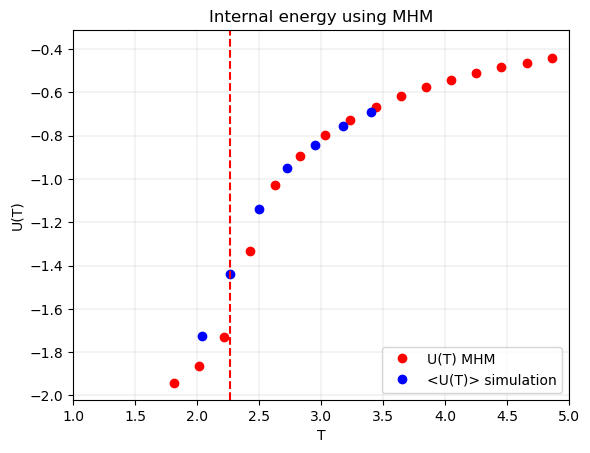

In [10]:
# plot internal enegy estimates via MHM vs the simulated mean
plt.plot(T_expanded,E_expanded,'ro', label='U(T) MHM', alpha=1)
plt.plot(T,mean,'bo',label='<U(T)> simulation',alpha=1)
plt.title('Interna Energy using MHM')
plt.xlabel('T')
plt.ylabel('U(T)')
plt.legend()
plt.xlim(1,5)
plt.axvline(x=T_critic, color='r', linestyle='--', label=f'T_critic = {T_critic}')
plt.grid(linewidth=0.2)

In [11]:
# define a set of new beta, where you want to compute the observable
n = 50
T_critic = 2.269
T_expanded = np.linspace(0.8*T_critic, 2.5*T_critic, n)
beta_expanded = 1/T_expanded
T = np.linspace(T_critic, 1.5 * T_critic, 7)
betas = 1 / T
num_temperatures = len(T)
# list to store the values of E
E_expanded = []

for beta in beta_expanded:
    
    # Z(beta)
    Z_beta = compute_Z_beta(num_temperatures, M, data16, Z_final, betas, beta)

    # E(beta)
    E_beta = compute_E_beta(data16, num_temperatures, M, betas, Z_final, Z_beta, beta)
    E_expanded.append(E_beta/16**2)

In [4]:
# plot internal enegy estimates via MHM vs the simulated mean
plt.plot(T_expanded,E_expanded,'ro', label='U(T) MHM', alpha=1)
plt.plot(T,mean,'bo',label='<U(T)> simulation',alpha=1)
plt.title('Internal energy using MHM')
plt.xlabel('T')
plt.ylabel('U(T)')
plt.legend()
plt.xlim(1,5)
plt.axvline(x=T_critic, color='r', linestyle='--', label=f'T_critic = {T_critic}')
plt.grid(linewidth=0.2)

NameError: name 'T_expanded' is not defined

---

In [13]:
#compute <E^2>_β

def compute_E2_beta(data_e, num_temperatures, M, betas, Z_k, Z_beta, beta):
    E2_beta = 0.0
    
    for i in range(len(Z_k)):
        for n in range(data_e[i].shape[0]):
            denominator = 0.0
            for j in range(len(Z_k)):
                denominator += M[j] / Z_k[j] * np.exp((beta - betas[j]) * data_e[i][n])
            E2_beta += data_e[i][n]**2 / denominator
    
    E2_beta /= Z_beta
    return E2_beta

In [14]:
# define a set of new beta, where you want to compute the observable
n = 20
T_critic = 2.269
T_expanded = np.linspace(0.5*T_critic, 2*T_critic, n)
beta_expanded = 1/T_expanded

# list to store the values of E
C_expanded16 = []

for k, beta in enumerate(beta_expanded):
    
    # Z(beta)
    Z_beta = compute_Z_beta(num_temperatures, M, data16, Z_final, betas, beta)

    # E(beta)
    E_beta = compute_E_beta(data16, num_temperatures, M, betas, Z_final, Z_beta, beta)
    E2_beta = compute_E2_beta(data16, num_temperatures, M, betas, Z_final, Z_beta, beta)
    C_expanded16.append((E2_beta-E_expanded[k]**2)/(16**2*beta**2))

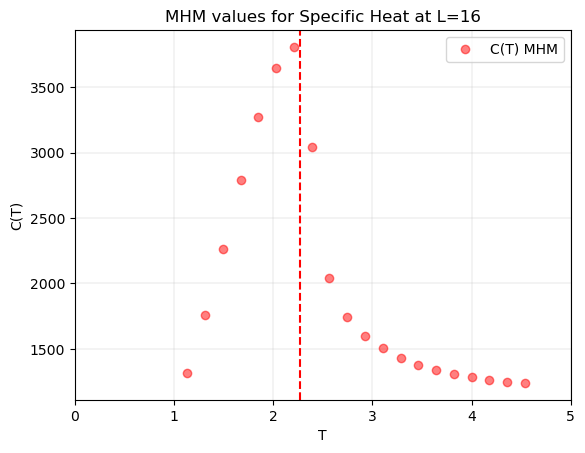

In [15]:
plt.plot(T_expanded,C_expanded16,'ro',label='C(T) MHM',alpha=0.5)
plt.title('MHM values for Specific Heat at L=16')
plt.xlabel('T')
plt.ylabel('C(T)')
plt.legend()
plt.xlim(0,5)
plt.axvline(x=T_critic, color='r', linestyle='--', label=f'T_critic = {T_critic}')
plt.grid(linewidth=0.2)

# L=32

In [16]:
Z_final = compute_partition_functions(data32, T_critic)
# define the matrix of the number of measurements
M = []
for j in range(len(data32)): 
    M.append(data32[j].shape[0])
M

Iteration 1
Z_new after iteration 1: [9.953393259559938e+18, 605874361.412409, 21.162805107864045, 1.3625289864211812e-05, 6.31112635621155e-11, 1.35247088114795e-15, 1.0046824976392142e-19]
Iteration 2
Z_new after iteration 2: [4.328741786782422e+20, 7162930704.078239, 35.455129852004134, 4.279560179367277e-06, 5.8497647139850055e-12, 5.4562687041195197e-17, 2.3101401036519332e-21]
Iteration 3
Z_new after iteration 3: [7.332220465843481e+21, 38763382236.00672, 57.15192037480225, 2.359069999062914e-06, 1.2839643035528897e-12, 5.622760693249036e-18, 1.3638433332145612e-22]
Iteration 4
Z_new after iteration 4: [6.672337382757554e+22, 125197773094.7009, 71.40988381095187, 1.310908745969897e-06, 3.6643766228601393e-13, 9.39890060269992e-19, 1.4987251732566293e-23]
Iteration 5
Z_new after iteration 5: [4.107674582903404e+23, 299400970467.2652, 75.25476190349038, 7.146615522342756e-07, 1.1894493999741793e-13, 2.051087480648421e-19, 2.4344674336231757e-24]
Iteration 6
Z_new after iteration 6:

Z_new after iteration 43: [7.334097230755219e+31, 67555461834161.75, 0.7939956433323565, 9.157180545070541e-12, 2.6678488955867625e-20, 4.374464036422259e-27, 1.363494331390295e-32]
Iteration 44
Z_new after iteration 44: [8.543462627604664e+31, 67868908834207.484, 0.7330073163035188, 8.089278171610878e-12, 2.315078838533214e-20, 3.767393963270714e-27, 1.170485602370301e-32]
Iteration 45
Z_new after iteration 45: [9.896092903527669e+31, 68057793695341.11, 0.6779191119350082, 7.174612760886452e-12, 2.0190458524151448e-20, 3.262335677406249e-27, 1.0104998101255995e-32]
Iteration 46
Z_new after iteration 46: [1.1401707963562263e+32, 68128607047022.99, 0.6280485898946048, 6.387642853292807e-12, 1.7692436667427283e-20, 2.839617576365745e-27, 8.770615798929548e-33]
Iteration 47
Z_new after iteration 47: [1.307006620872966e+32, 68087564565547.15, 0.5828041202949109, 5.707612304552541e-12, 1.5573369130513932e-20, 2.483789571012036e-27, 7.65107065281802e-33]
Iteration 48
Z_new after iteration 48

Z_new after iteration 85: [2.97933501243267e+33, 34461435618368.734, 0.07051484931955254, 3.65355143598362e-13, 7.845487084499794e-22, 1.134931400354316e-28, 3.356453691266782e-34]
Iteration 86
Z_new after iteration 86: [3.1435405074242794e+33, 33567080950560.3, 0.06746280140824575, 3.4742781571121153e-13, 7.444518681627428e-22, 1.0760192123814705e-28, 3.1811264961855682e-34]
Iteration 87
Z_new after iteration 87: [3.314364892762347e+33, 32690804178905.832, 0.06456509840705356, 3.305755005460855e-13, 7.0688607204342785e-22, 1.020897986626678e-28, 3.0171692989619902e-34]
Iteration 88
Z_new after iteration 88: [3.492012295608647e+33, 31832860911538.797, 0.06181256555556837, 3.147197328507709e-13, 6.716558824771227e-22, 9.692688817839938e-29, 2.8636783474604093e-34]
Iteration 89
Z_new after iteration 89: [3.676693095906202e+33, 30993448957694.977, 0.05919667810630347, 2.99788887123181e-13, 6.385838452764299e-22, 9.208611051498883e-29, 2.719835389887302e-34]
Iteration 90
Z_new after iterat

Z_new after iteration 127: [1.8637139575820796e+34, 11443806742883.6, 0.013909166642823984, 6.281038272152352e-14, 1.286625217052638e-22, 1.8277329944583782e-29, 5.365630256358474e-35]
Iteration 128
Z_new after iteration 128: [1.9327947926256325e+34, 11177202104896.666, 0.013450150800784736, 6.062234611988691e-14, 1.2410379612454346e-22, 1.7625686167185148e-29, 5.173854999068658e-35]
Iteration 129
Z_new after iteration 129: [2.0039248877427284e+34, 10918906151493.451, 0.01300913174219949, 5.852469474590759e-14, 1.197365727118477e-22, 1.7001588988311436e-29, 4.990206998858251e-35]
Iteration 130
Z_new after iteration 130: [2.0771483586842416e+34, 10668634131791.982, 0.012585316919196263, 5.651318661657511e-14, 1.1555167722552236e-22, 1.6403708399290516e-29, 4.814292613328037e-35]
Iteration 131
Z_new after iteration 131: [2.152509695327959e+34, 10426109633154.572, 0.012177951654368776, 5.458380255247819e-14, 1.1154043153133023e-22, 1.5830787108206328e-29, 4.645739817899583e-35]
Iteration 

Z_new after iteration 169: [7.068650713544698e+34, 4972869859226.469, 0.004047537356492541, 1.710294531710213e-14, 3.429622432869939e-23, 4.833982860880004e-30, 1.4146971473407721e-35]
Iteration 170
Z_new after iteration 170: [7.264858553116841e+34, 4892183590822.335, 0.003945984336290564, 1.665166029747063e-14, 3.337716356208409e-23, 4.703715511965561e-30, 1.3764892911383253e-35]
Iteration 171
Z_new after iteration 171: [7.465164258009113e+34, 4813471136480.3955, 0.0038476171436273984, 1.6215131770797914e-14, 3.248854428201887e-23, 4.5777831586948965e-30, 1.3395552534924266e-35]
Iteration 172
Z_new after iteration 172: [7.669618101575695e+34, 4736671543008.687, 0.00375231929095113, 1.5792800127446054e-14, 3.1629198761096366e-23, 4.456018814419288e-30, 1.3038458848355878e-35]
Iteration 173
Z_new after iteration 173: [7.878270266132369e+34, 4661726063075.912, 0.0036599790756179865, 1.5384129543441688e-14, 3.079800944734922e-23, 4.338262696481888e-30, 1.2693141593515348e-35]
Iteration 17

Z_new after iteration 210: [1.899143410507195e+35, 2806267315822.81, 0.0016150224910702524, 6.510507934009991e-15, 1.2862451953443815e-23, 1.803095534102497e-30, 5.2655317890550185e-36]
Iteration 211
Z_new after iteration 211: [1.9394693976830866e+35, 2773519672583.938, 0.0015837219420660798, 6.3780961398494955e-15, 1.2596982272963088e-23, 1.7656832840406527e-30, 5.1560493875005826e-36]
Iteration 212
Z_new after iteration 212: [1.9803903014854644e+35, 2741415722865.639, 0.0015532167969895256, 6.2491803071406185e-15, 1.2338605186843972e-23, 1.729274900142883e-30, 5.0495096812477505e-36]
Iteration 213
Z_new after iteration 213: [2.021909623988237e+35, 2709941056586.5454, 0.0015234832086350014, 6.123651618388851e-15, 1.2087097375334601e-23, 1.6938386427475974e-30, 4.945819477467493e-36]
Iteration 214
Z_new after iteration 214: [2.0640307875298116e+35, 2679081722822.077, 0.0014944981583609328, 6.001405155730944e-15, 1.1842243599142244e-23, 1.659343924659447e-30, 4.844888971819935e-36]
Iter

Z_new after iteration 251: [4.06745244027207e+35, 1873236947975.2986, 0.0007943879425649446, 3.090951177743474e-15, 6.039439202024664e-24, 8.432254492268469e-31, 2.458541346664426e-36]
Iteration 252
Z_new after iteration 252: [4.133903988630526e+35, 1858529052594.4568, 0.0007825028969620343, 3.0423595312283275e-15, 5.943074580482166e-24, 8.296991209144514e-31, 2.4190208644184766e-36]
Iteration 253
Z_new after iteration 253: [4.2009989682632744e+35, 1844110392296.6953, 0.0007708729504333824, 2.9948419591743667e-15, 5.8488597805958936e-24, 8.164755728100146e-31, 2.380386207077332e-36]
Iteration 254
Z_new after iteration 254: [4.268735450744357e+35, 1829975838358.9917, 0.0007594917249815023, 2.9483707116448098e-15, 5.7567386904652654e-24, 8.03546872703808e-31, 2.3426141337140626e-36]
Iteration 255
Z_new after iteration 255: [4.337111338457452e+35, 1816120353784.5552, 0.0007483530247541092, 2.9029188619587634e-15, 5.6666568820793236e-24, 7.909053274160925e-31, 2.3056821048907235e-36]
Itera

Z_new after iteration 292: [7.28239161933483e+35, 1460552240756.016, 0.0004630877766151094, 1.7499768036911536e-15, 3.38860179313101e-24, 4.715742137029373e-31, 1.3731752592719531e-36]
Iteration 293
Z_new after iteration 293: [7.371924737600004e+35, 1454290548165.0212, 0.0004579017557166648, 1.7292467301608267e-15, 3.347786495299218e-24, 4.658602245594203e-31, 1.3564978422793268e-36]
Iteration 294
Z_new after iteration 294: [7.461895192765757e+35, 1448165164757.7478, 0.00045281219963958836, 1.7089118899330873e-15, 3.3077554131012766e-24, 4.602563305881294e-31, 1.3401421142573694e-36]
Iteration 295
Z_new after iteration 295: [7.552295337598683e+35, 1442173516679.1555, 0.0004478169861802682, 1.688963391422516e-15, 3.2684907787558003e-24, 4.5476003094549875e-31, 1.3241007604953633e-36]
Iteration 296
Z_new after iteration 296: [7.643117444005367e+35, 1436313074134.6902, 0.00044291404571860163, 1.669392569053812e-15, 3.229975279741984e-24, 4.493688890555292e-31, 1.3083666544785566e-36]
Iter

Z_new after iteration 333: [1.1224820653000655e+36, 1292179867321.7288, 0.0003113565042535307, 1.1482238541281295e-15, 2.206773580667759e-24, 3.0627287185909863e-31, 8.908828309276165e-37]
Iteration 334
Z_new after iteration 334: [1.1325508795180423e+36, 1289807014315.8987, 0.00030882759856595783, 1.138294319016341e-15, 2.1873341194960316e-24, 3.0355702895131108e-31, 8.829625388888049e-37]
Iteration 335
Z_new after iteration 335: [1.142629142347807e+36, 1287494972382.56, 0.0003063394731251474, 1.128528837396967e-15, 2.1682182674469216e-24, 3.008865201572653e-31, 8.751745977222836e-37]
Iteration 336
Z_new after iteration 336: [1.1527160329119005e+36, 1285242519057.113, 0.00030389133189323705, 1.1189241410410147e-15, 2.149419536243434e-24, 2.9826043443480436e-31, 8.675163452649121e-37]
Iteration 337
Z_new after iteration 337: [1.1628107348740857e+36, 1283048454662.7454, 0.0003014823967386594, 1.1094770364772623e-15, 2.130931586820945e-24, 2.956778817341626e-31, 8.599851807424915e-37]
Ite

Z_new after iteration 374: [1.534886540630651e+36, 1233758758322.693, 0.00023415236489612151, 8.471553744597777e-16, 1.6186290501102684e-24, 2.2416877536028674e-31, 6.51513954633495e-37]
Iteration 375
Z_new after iteration 375: [1.5447342442858826e+36, 1233083222585.0247, 0.00023279614681578705, 8.419105976442612e-16, 1.60841022736516e-24, 2.2274360808615653e-31, 6.473605435362712e-37]
Iteration 376
Z_new after iteration 376: [1.5545630458826988e+36, 1232433350133.091, 0.00023145900478362233, 8.36741324343588e-16, 1.5983395757655801e-24, 2.2133915924146954e-31, 6.432675745435519e-37]
Iteration 377
Z_new after iteration 377: [1.5643724169985835e+36, 1231808582419.7231, 0.00023014061114324456, 8.31646229288829e-16, 1.5884144769680017e-24, 2.1995506181898965e-31, 6.392339759598979e-37]
Iteration 378
Z_new after iteration 378: [1.5741618376189464e+36, 1231208371611.4512, 0.00022884064488278393, 8.266240145482038e-16, 1.5786323669319649e-24, 2.1859095643793502e-31, 6.352586983766454e-37]
It

Z_new after iteration 415: [1.9183491387365374e+36, 1222102892331.2583, 0.0001912708578117649, 6.822614594264592e-16, 1.297923878541976e-24, 1.794705276392563e-31, 5.212815434934955e-37]
Iteration 416
Z_new after iteration 416: [1.927076216525072e+36, 1222118118791.3958, 0.0001904859468453021, 6.792630869573039e-16, 1.2921043769282521e-24, 1.7866004665051331e-31, 5.189208353176672e-37]
Iteration 417
Z_new after iteration 417: [1.9357693652706867e+36, 1222143102916.1475, 0.00018971082428028178, 6.763028829990856e-16, 1.2863594280247606e-24, 1.778599724872359e-31, 5.165904667884676e-37]
Iteration 418
Z_new after iteration 418: [1.944428375821258e+36, 1222177595692.7896, 0.00018894534215800867, 6.733802577852029e-16, 1.2806878720307164e-24, 1.7707014285619882e-31, 5.142899643077031e-37]
Iteration 419
Z_new after iteration 419: [1.953053045669325e+36, 1222221353077.1318, 0.00018818935519744853, 6.704946324272793e-16, 1.275088570665492e-24, 1.762903984819823e-31, 5.120188630909885e-37]
Iter

Z_new after iteration 456: [2.2467275550081716e+36, 1228514811726.3623, 0.0001657732032697738, 5.852899476275298e-16, 1.109973118161994e-24, 1.5330779807040108e-31, 4.450917948510954e-37]
Iteration 457
Z_new after iteration 457: [2.2539556506978339e+36, 1228770652659.2341, 0.00016529201609650083, 5.834690101384487e-16, 1.1064492588032723e-24, 1.528175548210467e-31, 4.4366445262150385e-37]
Iteration 458
Z_new after iteration 458: [2.2611459296519623e+36, 1229029280744.2927, 0.00016481626115869008, 5.816689837648597e-16, 1.1029660802064773e-24, 1.5233298193491178e-31, 4.42253632057229e-37]
Iteration 459
Z_new after iteration 459: [2.2682983966634222e+36, 1229290590148.652, 0.00016434586552958665, 5.798895819094019e-16, 1.0995230212674414e-24, 1.5185400102183786e-31, 4.408591045476912e-37]
Iteration 460
Z_new after iteration 460: [2.275413060280086e+36, 1229554477325.296, 0.0001638807574573751, 5.781305226858623e-16, 1.096119530162782e-24, 1.5138053499117104e-31, 4.394806452754155e-37]
It

Z_new after iteration 497: [2.5124548310953858e+36, 1240363865720.804, 0.00014982583862778613, 5.251407124726285e-16, 9.936930806389087e-25, 1.371368587470955e-31, 3.980171056703207e-37]
Iteration 498
Z_new after iteration 498: [2.5181702216174918e+36, 1240667711239.6997, 0.00014951816334925634, 5.239844687549214e-16, 9.914603793107503e-25, 1.3682648771569926e-31, 3.971137421193361e-37]
Iteration 499
Z_new after iteration 499: [2.5238504331297865e+36, 1240971487779.2383, 0.00014921369814985226, 5.228404531804676e-16, 9.892513893912002e-25, 1.3651941783955416e-31, 3.962199926244901e-37]
Iteration 500
Z_new after iteration 500: [2.529495576923667e+36, 1241275154852.2832, 0.00014891240419717507, 5.217085150944866e-16, 9.87065817105723e-25, 1.3621560813576e-31, 3.953357377347874e-37]
Final Z values: [2.529495576923667e+36, 1241275154852.2832, 0.00014891240419717507, 5.217085150944866e-16, 9.87065817105723e-25, 1.3621560813576e-31, 3.953357377347874e-37]


[1250, 95, 834, 1667, 2500, 2500, 2500]

In [17]:
# define a set of new beta, where you want to compute the observable
n = 20
T_critic = 2.269
T_expanded = np.linspace(0.5*T_critic, 2*T_critic, n)
beta_expanded = 1/T_expanded

# list to store the values of E
C_expanded32 = []

for k, beta in enumerate(beta_expanded):
    
    # Z(beta)
    Z_beta = compute_Z_beta(num_temperatures, M, data32, Z_final, betas, beta)

    # E(beta)
    E_beta = compute_E_beta(data32, num_temperatures, M, betas, Z_final, Z_beta, beta)
    E2_beta = compute_E2_beta(data32, num_temperatures, M, betas, Z_final, Z_beta, beta)
    C_expanded32.append((E2_beta-E_expanded[k]**2)/(32**2*beta**2))

/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4136397486.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  Z_beta += 1.0 / denominator
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4136397486.py:9: RuntimeWarning: overflow encountered in double_scalars
  Z_beta += 1.0 / denominator
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4078630638.py:11: RuntimeWarning: invalid value encountered in double_scalars
  E_beta /= Z_beta
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4282880303.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  E2_beta += data_e[i][n]**2 / denominator
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4282880303.py:11: RuntimeWarning: overflow encountered in double_scalars
  E2_beta += data_e[i][n]**2 / denominator
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4282880303.py:13: RuntimeWarning: invalid value encountered in double_s

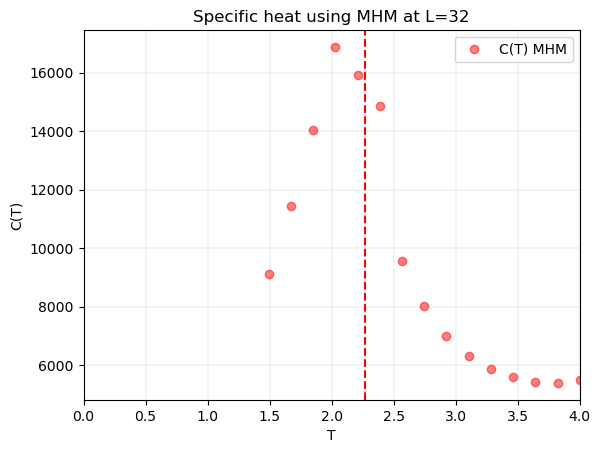

In [18]:

plt.plot(T_expanded,C_expanded32,'ro',label='C(T) MHM',alpha=0.5)
plt.title('Specific heat using MHM at L=32')
plt.xlabel('T')
plt.ylabel('C(T)')
plt.legend()
plt.xlim(0,4)
plt.axvline(x=T_critic, color='r', linestyle='--', label=f'T_critic = {T_critic}')
plt.grid(linewidth=0.2)

# L=48

In [19]:
Z_final = compute_partition_functions(data48, T_critic)
# define the matrix of the number of measurements
M = []
for j in range(len(data48)): 
    M.append(data48[j].shape[0])
M

Iteration 1
Z_new after iteration 1: [4.8837747411024296e+42, 3.8317776031779376e+20, 9971.307570417624, 8.809942377539062e-11, 4.971419368289108e-23, 7.972355567429675e-34, 2.047596486348727e-43]
Iteration 2
Z_new after iteration 2: [8.83330039087062e+44, 9.77736089510376e+21, 8856.537429134294, 7.170984308707334e-12, 9.18648730767852e-25, 6.521412203883056e-36, 1.1320796936029917e-45]
Iteration 3
Z_new after iteration 3: [6.362153103500873e+46, 1.74664196059978e+23, 24619.08372305336, 3.310038362882492e-12, 9.899644750555798e-26, 2.2045002281472248e-37, 1.5717949312627113e-47]
Iteration 4
Z_new after iteration 4: [1.860950774382466e+48, 1.477019555753825e+24, 56360.059176367446, 2.18825049276831e-12, 2.0654561550699228e-26, 1.6756535005056056e-38, 5.373597269556138e-49]
Iteration 5
Z_new after iteration 5: [2.874200032679244e+49, 7.183648782526999e+24, 93682.34546543912, 1.396208624402319e-12, 5.545021346178516e-27, 2.084433796140067e-39, 3.4792289632946308e-50]
Iteration 6
Z_new aft

Z_new after iteration 43: [3.91918968478879e+64, 1.1992335812140773e+30, 313.9566482932507, 1.8463194231095376e-20, 2.0049416309038069e-38, 3.796673907538919e-53, 2.5515478464367594e-65]
Iteration 44
Z_new after iteration 44: [6.166349684518643e+64, 1.2955378957403295e+30, 271.664646448758, 1.3537344031663501e-20, 1.350556216458427e-38, 2.4528803011303134e-53, 1.6217049813289363e-65]
Iteration 45
Z_new after iteration 45: [9.608474335922667e+64, 1.387959531673292e+30, 234.63916196387328, 9.971944087077407e-21, 9.166487750707407e-39, 1.5990929891797684e-53, 1.0407479533575436e-65]
Iteration 46
Z_new after iteration 46: [1.4834699322189078e+65, 1.4760632591857353e+30, 202.20124750989999, 7.376574563292812e-21, 6.265805643898331e-39, 1.0514705027312293e-53, 6.740952265235634e-66]
Iteration 47
Z_new after iteration 47: [2.270331677979528e+65, 1.5595755397759432e+30, 173.8091906443707, 5.477689680043251e-21, 4.311791993495912e-39, 6.970497352844769e-54, 4.404642765192555e-66]
Iteration 48
Z

Z_new after iteration 85: [2.2600765848175057e+70, 2.0967472618170498e+31, 0.9864220442568341, 9.60283969824477e-25, 1.2885077897307068e-43, 9.359243587828884e-59, 4.424628823278336e-71]
Iteration 86
Z_new after iteration 86: [2.764348967893237e+70, 2.2211090299479334e+31, 0.9182583847757048, 8.299185993652564e-25, 1.0743828643696947e-43, 7.689897197252798e-59, 3.617488282465724e-71]
Iteration 87
Z_new after iteration 87: [3.3666468282782485e+70, 2.3454096211444223e+31, 0.8570333730868034, 7.19857116292176e-25, 8.994812232070475e-44, 6.345092070648703e-59, 2.9703145325505217e-71]
Iteration 88
Z_new after iteration 88: [4.083033191964284e+70, 2.4688864492218556e+31, 0.8017910242646412, 6.265625250204779e-25, 7.560214680272576e-44, 5.2570961601928215e-59, 2.4491596148864894e-71]
Iteration 89
Z_new after iteration 89: [4.931690630019149e+70, 2.5908083774657993e+31, 0.7517210320447789, 5.471683284167067e-25, 6.378692598364329e-44, 4.37316816561961e-59, 2.027702212123791e-71]
Iteration 90
Z

Z_new after iteration 126: [7.247430513509438e+72, 3.765978060776984e+31, 0.10869810869873894, 1.362028460004352e-26, 6.876385935811268e-46, 3.3387883282608215e-61, 1.379799362182181e-73]
Iteration 127
Z_new after iteration 127: [8.004888659795232e+72, 3.698179039682085e+31, 0.10320777198029037, 1.2573348522559844e-26, 6.2684879597201455e-46, 3.0279908746556626e-61, 1.249236613399168e-73]
Iteration 128
Z_new after iteration 128: [8.831703266168865e+72, 3.626477128909245e+31, 0.09796301260641761, 1.1612762499660412e-26, 5.719460854505763e-46, 2.749028727108669e-61, 1.1322844188285253e-73]
Iteration 129
Z_new after iteration 129: [9.733526583033019e+72, 3.551209256154063e+31, 0.09295331736540219, 1.073068312461622e-26, 5.223008157284317e-46, 2.498302197812252e-61, 1.0273768623010167e-73]
Iteration 130
Z_new after iteration 130: [1.0716439161251818e+73, 3.4727242120367274e+31, 0.08816887616403764, 9.920064155911816e-27, 4.7735760643599105e-46, 2.2726588139907535e-61, 9.331457818710623e-74

Z_new after iteration 167: [2.38938499717893e+74, 7.19816944646852e+30, 0.00972294648625718, 6.396422135747578e-28, 2.4338471979968055e-47, 1.052138629908016e-62, 4.185177362294766e-75]
Iteration 168
Z_new after iteration 168: [2.579450770613834e+74, 6.798567743380742e+30, 0.0091100696702963, 5.952281552162905e-28, 2.2581645349900793e-47, 9.750023067708992e-63, 3.87679428269154e-75]
Iteration 169
Z_new after iteration 169: [2.784041300760525e+74, 6.417848596602177e+30, 0.008534024679319862, 5.539222581804361e-28, 2.0954850603182078e-47, 9.037006372772165e-63, 3.591900736985571e-75]
Iteration 170
Z_new after iteration 170: [3.0042430798899996e+74, 6.055454267216506e+30, 0.00799276774486984, 5.155040063186815e-28, 1.944811473977497e-47, 8.377730300619339e-63, 3.3286254587515445e-75]
Iteration 171
Z_new after iteration 171: [3.2412228226148365e+74, 5.71081226082674e+30, 0.007484355310725294, 4.797689615723513e-28, 1.8052269248682642e-47, 7.767973922573643e-63, 3.08525533333514e-75]
Iterat

Z_new after iteration 208: [4.834163009385341e+75, 5.950752354963883e+29, 0.0006277315257201277, 3.501124801964548e-29, 1.2465191245242794e-48, 5.2459638118414746e-64, 2.068610425545309e-76]
Iteration 209
Z_new after iteration 209: [5.183725359371865e+75, 5.628794416099968e+29, 0.0005885396281068812, 3.2705022797541464e-29, 1.1630791957837315e-48, 4.892812828540389e-64, 1.9291145473053653e-76]
Iteration 210
Z_new after iteration 210: [5.55727123743646e+75, 5.3275823608641064e+29, 0.0005519902789040226, 3.055864774790848e-29, 1.0854839458536542e-48, 4.5645027876491506e-64, 1.799444290686259e-76]
Iteration 211
Z_new after iteration 211: [5.9563153128634845e+75, 5.045673123159052e+29, 0.0005179001166405241, 2.856080213866939e-29, 1.0133145009297048e-48, 4.2592436706972074e-64, 1.6788902995789396e-76]
Iteration 212
Z_new after iteration 212: [6.382456588690733e+75, 4.7817223932718296e+29, 0.00048609808273444475, 2.6700957955798945e-29, 9.461820347912241e-49, 3.975375239781481e-64, 1.566794

Z_new after iteration 248: [6.336724272236086e+76, 1.0173383703318368e+29, 6.529736809699074e-05, 2.9423563803443064e-30, 9.803843419988053e-50, 4.03042594534054e-65, 1.5781024343783267e-77]
Iteration 249
Z_new after iteration 249: [6.714697246651021e+76, 9.837589170005521e+28, 6.221334735408585e-05, 2.7852275129125107e-30, 9.261035426612558e-50, 3.804421087565903e-65, 1.4892704216839465e-77]
Iteration 250
Z_new after iteration 250: [7.11285718998091e+76, 9.517387515982363e+28, 5.9297576735449456e-05, 2.637409583979405e-30, 8.751234811327096e-50, 3.592285400635719e-65, 1.4059047908463403e-77]
Iteration 251
Z_new after iteration 251: [7.53212304262631e+76, 9.21195048692773e+28, 5.653995070001653e-05, 2.4983083897705112e-30, 8.2722946339698295e-50, 3.393110796702603e-65, 1.3276469254959476e-77]
Iteration 252
Z_new after iteration 252: [7.973446020785495e+76, 8.92049544761928e+28, 5.3931014053638294e-05, 2.3673698546771403e-30, 7.82221485593852e-50, 3.2060515795594108e-65, 1.2541628768705

Z_new after iteration 288: [4.972774606734431e+77, 3.6270670947656376e+28, 1.2398098753093375e-05, 4.2642691293834246e-31, 1.3022920771027496e-50, 5.186224997970206e-66, 2.0109497797180274e-78]
Iteration 289
Z_new after iteration 289: [5.201886515542035e+77, 3.556392245282413e+28, 1.1967547429233528e-05, 4.089374628854686e-31, 1.2462190802046974e-50, 4.959008722760071e-66, 1.922379500229832e-78]
Iteration 290
Z_new after iteration 290: [5.43997758390206e+77, 3.4878004909451083e+28, 1.1554761867584253e-05, 3.9227357415145997e-31, 1.1929012151731294e-50, 4.7431171783476396e-66, 1.838242868792681e-78]
Iteration 291
Z_new after iteration 291: [5.687329850538437e+77, 3.4212094490271175e+28, 1.1158891385221773e-05, 3.7639156451124084e-31, 1.1421880936553568e-50, 4.537925326584549e-66, 1.7582943600595396e-78]
Iteration 292
Z_new after iteration 292: [5.944231631658082e+77, 3.3565411565404643e+28, 1.0779132018399293e-05, 3.6125029847162075e-31, 1.093938283379722e-50, 4.3428456391746373e-66, 1.

Z_new after iteration 328: [2.4535363514535834e+78, 1.8781302430365807e+28, 3.5476054216773055e-06, 9.67373696841106e-32, 2.738652679071599e-51, 1.0603292153263326e-66, 4.0757496802831383e-79]
Iteration 329
Z_new after iteration 329: [2.541025558280012e+78, 1.8526845431536739e+28, 3.4510287551077416e-06, 9.363323011582859e-32, 2.6464607445309648e-51, 1.0240135105451038e-66, 3.9354188970727524e-79]
Iteration 330
Z_new after iteration 330: [2.6310776195005557e+78, 1.8277949043286552e+28, 3.357603650999006e-06, 9.064616849327941e-32, 2.5578977166990206e-51, 9.891494573003598e-67, 3.80072405537707e-79]
Iteration 331
Z_new after iteration 331: [2.7237491320540886e+78, 1.803446460607002e+28, 3.2672117076471607e-06, 8.777117877556967e-32, 2.472802312513029e-51, 9.556716335237151e-67, 3.6714100730923783e-79]
Iteration 332
Z_new after iteration 332: [2.8190974258514096e+78, 1.7796249205397203e+28, 3.17973957845762e-06, 8.500349302850491e-32, 2.391021185733774e-51, 9.235178765782574e-67, 3.54723

Z_new after iteration 368: [8.573259899767107e+78, 1.1860660063023805e+28, 1.3141867222694068e-06, 3.0097657680891165e-32, 8.055096732042239e-52, 3.054162641938777e-67, 1.1664174557768454e-79]
Iteration 369
Z_new after iteration 369: [8.813894272634048e+78, 1.17513519586199e+28, 1.2854231257314103e-06, 2.9328172235915205e-32, 7.839744650244952e-52, 2.9711865053689675e-67, 1.1345722663191737e-79]
Iteration 370
Z_new after iteration 370: [9.059836834675134e+78, 1.1644313578194397e+28, 1.2574432843366244e-06, 2.858256124740859e-32, 7.631335807123066e-52, 2.89092311132819e-67, 1.1037726376844378e-79]
Iteration 371
Z_new after iteration 371: [9.31116541665903e+78, 1.1539498573214867e+28, 1.2302226534384812e-06, 2.7859977851211805e-32, 7.429614681700077e-52, 2.813271288599368e-67, 1.0739794163798816e-79]
Iteration 372
Z_new after iteration 372: [9.567958096262665e+78, 1.1436861396029047e+28, 1.2037375387698301e-06, 2.7159608587043337e-32, 7.234336209918123e-52, 2.7381340611612427e-67, 1.0451

Z_new after iteration 408: [2.3122421497868167e+79, 8.864451648041395e+27, 5.930557308079617e-07, 1.1881878506325291e-32, 3.04838542097744e-52, 1.1378771672876187e-67, 4.324806552342269e-80]
Iteration 409
Z_new after iteration 409: [2.3637436547152534e+79, 8.816492069075596e+27, 5.826350916591028e-07, 1.1638899602148265e-32, 2.9832959897638568e-52, 1.1132015510205973e-67, 4.230577194803572e-80]
Iteration 410
Z_new after iteration 410: [2.4160953017759548e+79, 8.769458935009183e+27, 5.72452048875594e-07, 1.1402189009469104e-32, 2.9199467117525467e-52, 1.0891941549164292e-67, 4.138909583843604e-80]
Iteration 411
Z_new after iteration 411: [2.4693050472682864e+79, 8.723330374598611e+27, 5.625000934340366e-07, 1.1171556588993852e-32, 2.8582831569205214e-52, 1.0658338434266571e-67, 4.049722415245002e-80]
Iteration 412
Z_new after iteration 412: [2.5233808378322667e+79, 8.678085004234226e+27, 5.527729181383677e-07, 1.0946818690000461e-32, 2.7982528080483536e-52, 1.043100231776732e-67, 3.9629

Z_new after iteration 449: [5.204579326070175e+79, 7.468149397525812e+27, 3.0753001365234517e-07, 5.544433078930405e-33, 1.3761583539558413e-52, 5.074302116621162e-68, 1.9213848754133037e-80]
Iteration 450
Z_new after iteration 450: [5.2973360074253454e+79, 7.444647589438157e+27, 3.0312603027620393e-07, 5.4529560971082217e-33, 1.3525153484191407e-52, 4.9858437022e-68, 1.8877413073255816e-80]
Iteration 451
Z_new after iteration 451: [5.3912591210825715e+79, 7.421493204199002e+27, 2.988050179273255e-07, 5.3634320821857935e-33, 1.329395277004801e-52, 4.899366768544722e-68, 1.854854269737268e-80]
Iteration 452
Z_new after iteration 452: [5.486356108007822e+79, 7.398678223156867e+27, 2.9456505164893546e-07, 5.275810768954809e-33, 1.3067842699468012e-52, 4.814818190056649e-68, 1.8227034124533253e-80]
Iteration 453
Z_new after iteration 453: [5.58263439634588e+79, 7.376194831419631e+27, 2.9040425902382084e-07, 5.190043383320507e-33, 1.284668879550133e-52, 4.732146472845195e-68, 1.791269012089

Z_new after iteration 489: [9.897046652265421e+79, 6.735605299910762e+27, 1.8098290358695926e-07, 3.0215799341958328e-33, 7.321536268579344e-53, 2.675737665316658e-68, 1.010402431286005e-80]
Iteration 490
Z_new after iteration 490: [1.0042143070904979e+80, 6.721372667033627e+27, 1.7879687689908173e-07, 2.980187838484379e-33, 7.217539015709001e-53, 2.6372301939163572e-68, 9.958033787601494e-81]
Iteration 491
Z_new after iteration 491: [1.0188694099329236e+80, 6.707285561710669e+27, 1.7664572972886227e-07, 2.93953983517578e-33, 7.115475227407376e-53, 2.5994473283318007e-68, 9.81480050584534e-81]
Iteration 492
Z_new after iteration 492: [1.033670670515832e+80, 6.69334116272628e+27, 1.7452877420022087e-07, 2.8996195777662885e-33, 7.0153011210051485e-53, 2.562372481003234e-68, 9.674261140649086e-81]
Iteration 493
Z_new after iteration 493: [1.048618784483777e+80, 6.679536721346651e+27, 1.7244533858624046e-07, 2.8604111400186763e-33, 6.916974069479912e-53, 2.5259895063594874e-68, 9.536354057

[1250, 167, 834, 1250, 1667, 2500, 2500]

In [20]:
# define a set of new beta, where you want to compute the observable
n = 20
T_critic = 2.269
T_expanded = np.linspace(0.5*T_critic, 2*T_critic, n)
beta_expanded = 1/T_expanded

# list to store the values of E
C_expanded48 = []

for k, beta in enumerate(beta_expanded):
    
    # Z(beta)
    Z_beta = compute_Z_beta(num_temperatures, M, data48, Z_final, betas, beta)

    # E(beta)
    E_beta = compute_E_beta(data48, num_temperatures, M, betas, Z_final, Z_beta, beta)
    E2_beta = compute_E2_beta(data48, num_temperatures, M, betas, Z_final, Z_beta, beta)
    C_expanded48.append((E2_beta-E_expanded[k]**2)/(48**2*beta**2))

/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4136397486.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  Z_beta += 1.0 / denominator
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4136397486.py:9: RuntimeWarning: overflow encountered in double_scalars
  Z_beta += 1.0 / denominator
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4078630638.py:11: RuntimeWarning: invalid value encountered in double_scalars
  E_beta /= Z_beta
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4282880303.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  E2_beta += data_e[i][n]**2 / denominator
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4282880303.py:11: RuntimeWarning: overflow encountered in double_scalars
  E2_beta += data_e[i][n]**2 / denominator
/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_6829/4282880303.py:13: RuntimeWarning: invalid value encountered in double_s

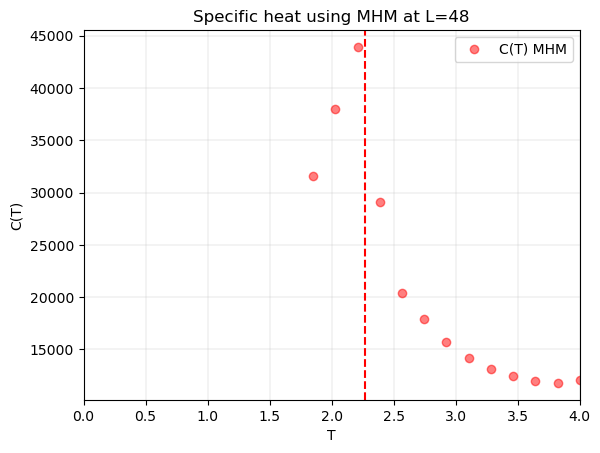

In [21]:
plt.plot(T_expanded,C_expanded48,'ro',label='C(T) MHM',alpha=0.5)
plt.title('Specific heat using MHM at L=48')
plt.xlabel('T')
plt.ylabel('C(T)')
plt.legend()
plt.xlim(0,4)
plt.axvline(x=T_critic, color='r', linestyle='--', label=f'T_critic = {T_critic}')
plt.grid(linewidth=0.2)

## Tot

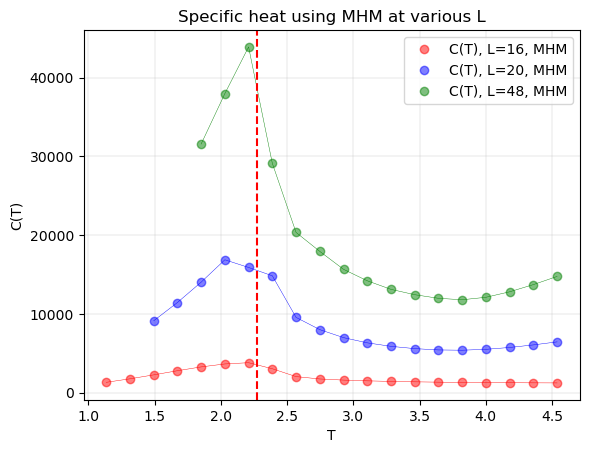

In [23]:
# Final plot
plt.plot(T_expanded, C_expanded16, 'ro', label='C(T), L=16, MHM', alpha=0.5)
plt.plot(T_expanded, C_expanded32, 'bo', label='C(T), L=20, MHM', alpha=0.5)
plt.plot(T_expanded, C_expanded48, 'go', label='C(T), L=48, MHM', alpha=0.5)

plt.plot(T_expanded, C_expanded16, 'r-', linewidth=0.3)
plt.plot(T_expanded, C_expanded32, 'b-', linewidth=0.3)
plt.plot(T_expanded, C_expanded48, 'g-', linewidth=0.3)

plt.title('Specific heat using MHM at various L')
plt.xlabel('T')
plt.ylabel('C(T)')
plt.legend()
#plt.xlim(1,3)
plt.axvline(x=T_critic, color='r', linestyle='--', label=f'T_critic = {T_critic}')
plt.grid(linewidth=0.2)